# Dataset

In [1]:
from sklearn import datasets
digits = datasets.load_digits(as_frame=True)
df = digits.frame

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pixel_0_0  1797 non-null   float64
 1   pixel_0_1  1797 non-null   float64
 2   pixel_0_2  1797 non-null   float64
 3   pixel_0_3  1797 non-null   float64
 4   pixel_0_4  1797 non-null   float64
 5   pixel_0_5  1797 non-null   float64
 6   pixel_0_6  1797 non-null   float64
 7   pixel_0_7  1797 non-null   float64
 8   pixel_1_0  1797 non-null   float64
 9   pixel_1_1  1797 non-null   float64
 10  pixel_1_2  1797 non-null   float64
 11  pixel_1_3  1797 non-null   float64
 12  pixel_1_4  1797 non-null   float64
 13  pixel_1_5  1797 non-null   float64
 14  pixel_1_6  1797 non-null   float64
 15  pixel_1_7  1797 non-null   float64
 16  pixel_2_0  1797 non-null   float64
 17  pixel_2_1  1797 non-null   float64
 18  pixel_2_2  1797 non-null   float64
 19  pixel_2_3  1797 non-null   float64
 20  pixel_2_

In [3]:
df = df.drop(df.loc[~df["target"].isin([2, 7])].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 2 to 1785
Data columns (total 65 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pixel_0_0  356 non-null    float64
 1   pixel_0_1  356 non-null    float64
 2   pixel_0_2  356 non-null    float64
 3   pixel_0_3  356 non-null    float64
 4   pixel_0_4  356 non-null    float64
 5   pixel_0_5  356 non-null    float64
 6   pixel_0_6  356 non-null    float64
 7   pixel_0_7  356 non-null    float64
 8   pixel_1_0  356 non-null    float64
 9   pixel_1_1  356 non-null    float64
 10  pixel_1_2  356 non-null    float64
 11  pixel_1_3  356 non-null    float64
 12  pixel_1_4  356 non-null    float64
 13  pixel_1_5  356 non-null    float64
 14  pixel_1_6  356 non-null    float64
 15  pixel_1_7  356 non-null    float64
 16  pixel_2_0  356 non-null    float64
 17  pixel_2_1  356 non-null    float64
 18  pixel_2_2  356 non-null    float64
 19  pixel_2_3  356 non-null    float64
 20  pixel_2_4

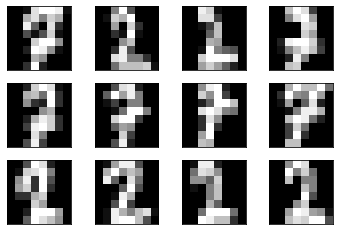

In [4]:
import matplotlib.pyplot as plt

pixels = [col for col in df.columns if col.startswith("pixel")]
sample = df.sample(12)

fig, axs = plt.subplots(3, 4)
for ax, index in zip(axs.flat, sample.index):
    img = sample.loc[index, pixels].values.reshape((8, 8))
    lbl = sample.loc[index, "target"]
    ax.imshow(img, cmap="gray")
    ax.tick_params(
        left=False,
        bottom=False,
        labelleft=False,
        labelbottom=False)

# Features

In [5]:
import numpy as np

def symmetry(flat_pixels):
    img = flat_pixels.values.reshape((8, 8))
    return abs(img[:4,:] - np.flip(img[4:, :], axis=0)).mean()
    
df["symmetry"] = df[pixels].apply(symmetry, axis="columns")
df["intensity"] = df[pixels].mean(axis="columns")
df["label"] = (df["target"] == 2).astype(int)

df = df[["intensity", "symmetry", "label"]]
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 2 to 1785
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   intensity  356 non-null    float64
 1   symmetry   356 non-null    float64
 2   label      356 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.1 KB


,intensity,symmetry,label
949,4.468750,4.18750,0
1492,5.125000,4.00000,1
1348,5.375000,4.12500,0
1403,5.156250,4.18750,1
857,3.718750,2.87500,0
1373,4.015625,4.28125,0
1499,4.656250,3.00000,1
1140,4.906250,4.00000,1
1368,4.875000,4.75000,0
727,4.765625,3.96875,0


<AxesSubplot:xlabel='Intensity', ylabel='Symmetry'>

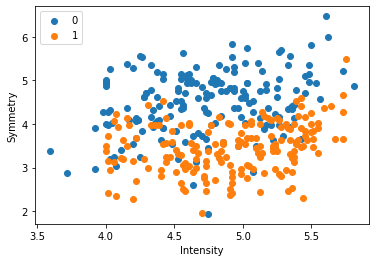

In [6]:
def plot_data(ax, df):
    for name, data in df.groupby("label"):
        ax.scatter("intensity", "symmetry", data=data, label=name)
    ax.legend()
    ax.set(xlabel="Intensity", ylabel="Symmetry")
    return ax

fix, ax = plt.subplots()
plot_data(ax, df)

# Random Seed

In [7]:
np.random.seed(934545)

# Part 1

## Train-Val Split

In [8]:
df = df.sample(frac=1).reset_index(drop=True)
split = 260
train, val = df.iloc[:split, :], df.iloc[split:, :]

X_tr, Y_tr = train[["intensity", "symmetry"]], train["label"] 
X_val, Y_val = val[["intensity", "symmetry"]], val["label"]

## Plotting Utilities

In [9]:
import pandas as pd

def plot_decision_boundary(ax, m):
    x_min, x_max = df["intensity"].min() - 1, df["intensity"].max() + 1
    y_min, y_max = df["symmetry"].min() - 1, df["symmetry"].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.01),
        np.arange(y_min, y_max, 0.01))
    dz = np.c_[xx.ravel(), yy.ravel()]
    _df = pd.DataFrame({
        "intensity": dz[:, 0],
        "symmetry": dz[:, 1]
    })
    
    Z = m.predict(_df).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.2)
    
    return ax

def plot_results(ax1, ax2, m, train, val):
    plot_decision_boundary(ax1, m)
    plot_decision_boundary(ax2, m)
    plot_data(ax1, train)
    plot_data(ax2, val)
    return ax1, ax2

## Model 1: A Simple Perceptron

In [10]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("scaler", StandardScaler()),
    ("perceptron", Perceptron(eta0=0.003))
])
model.fit(X_tr, Y_tr)

Pipeline(steps=[('scaler', StandardScaler()),
                ('perceptron', Perceptron(eta0=0.003))])

Model 1
Train: 0.7423076923076923
Val: 0.7604166666666666


(<AxesSubplot:xlabel='Intensity', ylabel='Symmetry'>,
 <AxesSubplot:xlabel='Intensity', ylabel='Symmetry'>)

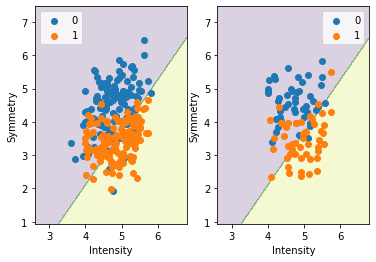

In [11]:
print("Model 1")
print("Train:", model.score(X_tr, Y_tr))
print("Val:", model.score(X_val, Y_val))
fig, (ax1, ax2) = plt.subplots(ncols=2)
plot_results(ax1, ax2, model, train, val)

In [12]:
model[1].coef_, model[1].intercept_

(array([[ 0.00402668, -0.00447418]]), array([-0.003]))

## Feature Tranfsorms: The Polynomial Case

In [13]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
X_tr[:5], poly.fit_transform(X_tr, Y_tr).round(2)[:5]

(   intensity  symmetry
 0   5.265625   5.03125
 1   5.296875   3.71875
 2   5.234375   4.21875
 3   5.281250   2.81250
 4   4.656250   3.00000,
 array([[ 5.27,  5.03, 27.73, 26.49, 25.31],
        [ 5.3 ,  3.72, 28.06, 19.7 , 13.83],
        [ 5.23,  4.22, 27.4 , 22.08, 17.8 ],
        [ 5.28,  2.81, 27.89, 14.85,  7.91],
        [ 4.66,  3.  , 21.68, 13.97,  9.  ]]))

## Model 2: Adding Model Complexity

In [14]:
model2 = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(2, include_bias=False)),
    ("perceptron", Perceptron(eta0=0.003))
])
model2.fit(X_tr, Y_tr)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('perceptron', Perceptron(eta0=0.003))])

Model 2
Train: 0.8115384615384615
Val: 0.8125


(<AxesSubplot:xlabel='Intensity', ylabel='Symmetry'>,
 <AxesSubplot:xlabel='Intensity', ylabel='Symmetry'>)

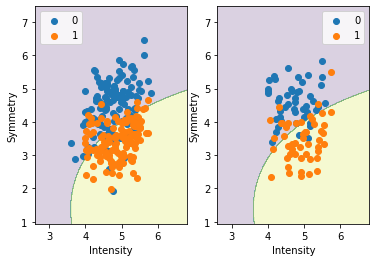

In [15]:
print("Model 2")
print("Train:", model2.score(X_tr, Y_tr))
print("Val:", model2.score(X_val, Y_val))
fig, (ax1, ax2) = plt.subplots(ncols=2)
plot_results(ax1, ax2, model2, train, val)

## Model 3: Overfitting

In [16]:
model3 = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(8, include_bias=False)),
    ("perceptron", Perceptron(eta0=0.003))
])
model3.fit(X_tr, Y_tr)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=8, include_bias=False)),
                ('perceptron', Perceptron(eta0=0.003))])

Model 3
Train: 0.7269230769230769
Val: 0.7395833333333334


(<AxesSubplot:xlabel='Intensity', ylabel='Symmetry'>,
 <AxesSubplot:xlabel='Intensity', ylabel='Symmetry'>)

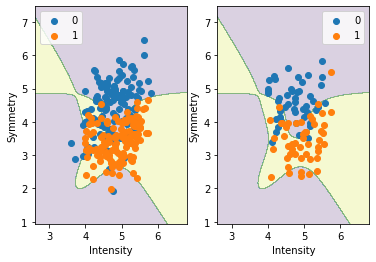

In [17]:
print("Model 3")
print("Train:", model3.score(X_tr, Y_tr))
print("Val:", model3.score(X_val, Y_val))
fig, (ax1, ax2) = plt.subplots(ncols=2)
plot_results(ax1, ax2, model3, train, val)

## Model 4: Regularization

In [28]:
model4 = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(8, include_bias=False)),
    ("perceptron", Perceptron(eta0=0.003, penalty="elasticnet", alpha=1e-1))
])
model4.fit(X_tr, Y_tr)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=8, include_bias=False)),
                ('perceptron',
                 Perceptron(alpha=0.1, eta0=0.003, penalty='elasticnet'))])

Model 4
Train: 0.7923076923076923
Val: 0.8125


(<AxesSubplot:xlabel='Intensity', ylabel='Symmetry'>,
 <AxesSubplot:xlabel='Intensity', ylabel='Symmetry'>)

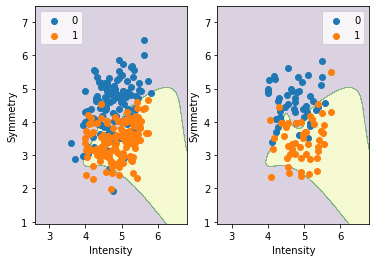

In [29]:
print("Model 4")
print("Train:", model4.score(X_tr, Y_tr))
print("Val:", model4.score(X_val, Y_val))
fig, (ax1, ax2) = plt.subplots(ncols=2)
plot_results(ax1, ax2, model4, train, val)

# Part 2

## Learning Rates

In [20]:
from sklearn.linear_model import SGDClassifier
scaler = StandardScaler()
poly = PolynomialFeatures(8, include_bias=False)
X_t = scaler.fit_transform(X_tr)
X_tp = poly.fit_transform(X_t)
X_tp_val = poly.transform(scaler.transform(X_val))

model5 = SGDClassifier(
    alpha=0,
    loss="hinge",
    learning_rate="constant",
    eta0=1e-6)


tr_score, val_score = [], []
for i in range(50):
    idx = list(range(X_t.shape[0]))
    np.random.shuffle(idx)
    #idx = idx[:B]
    if i == 0:
        model5.partial_fit(X_tp[idx], Y_tr[idx], classes=np.unique(Y_tr))
    else:
        model5.partial_fit(X_tp[idx], Y_tr[idx])
    tr_score.append(model5.score(X_tp[idx], Y_tr[idx]))
    val_score.append(model5.score(X_tp_val, Y_val))

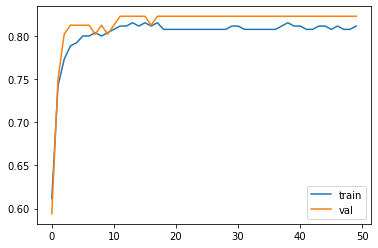

In [21]:
fig, ax = plt.subplots()
ax.plot(tr_score, label="train")
ax.plot(val_score, label="val")
ax.legend()

## Multilayer Perceptron

In [22]:
from sklearn.neural_network import MLPClassifier

model6 = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        verbose=1,
        hidden_layer_sizes=(50, 50),
        learning_rate_init=0.01,
        solver="sgd", # default 'adam' is much better...
        momentum=0,
        max_iter=1000))
])
model6.fit(X_tr, Y_tr)

Iteration 1, loss = 0.69848543
Iteration 2, loss = 0.69541979
Iteration 3, loss = 0.69255289
Iteration 4, loss = 0.68994900
Iteration 5, loss = 0.68735053
Iteration 6, loss = 0.68493007
Iteration 7, loss = 0.68232683
Iteration 8, loss = 0.67975096
Iteration 9, loss = 0.67748398
Iteration 10, loss = 0.67506737
Iteration 11, loss = 0.67273084
Iteration 12, loss = 0.67045961
Iteration 13, loss = 0.66821110
Iteration 14, loss = 0.66582246
Iteration 15, loss = 0.66346830
Iteration 16, loss = 0.66110396
Iteration 17, loss = 0.65886025
Iteration 18, loss = 0.65657535
Iteration 19, loss = 0.65433654
Iteration 20, loss = 0.65228556
Iteration 21, loss = 0.65026260
Iteration 22, loss = 0.64800811
Iteration 23, loss = 0.64564739
Iteration 24, loss = 0.64355614
Iteration 25, loss = 0.64154783
Iteration 26, loss = 0.63936494
Iteration 27, loss = 0.63728177
Iteration 28, loss = 0.63534093
Iteration 29, loss = 0.63317874
Iteration 30, loss = 0.63130651
Iteration 31, loss = 0.62939212
Iteration 32, los

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(hidden_layer_sizes=(50, 50),
                               learning_rate_init=0.01, max_iter=1000,
                               momentum=0, solver='sgd', verbose=1))])

Model 6
Train: 0.8076923076923077
Val: 0.8333333333333334


(<AxesSubplot:xlabel='Intensity', ylabel='Symmetry'>,
 <AxesSubplot:xlabel='Intensity', ylabel='Symmetry'>)

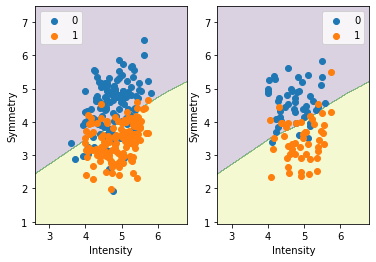

In [23]:
print("Model 6")
print("Train:", model6.score(X_tr, Y_tr))
print("Val:", model6.score(X_val, Y_val))
fig, (ax1, ax2) = plt.subplots(ncols=2)
plot_results(ax1, ax2, model6, train, val)

## Support Vector Machine

In [24]:
from sklearn.svm import SVC

model7 = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", SVC(C=0.5, kernel="rbf"))
])
model7.fit(X_tr, Y_tr)

Pipeline(steps=[('scaler', StandardScaler()), ('mlp', SVC(C=0.5))])

Model 7
Train: 0.8
Val: 0.84375


(<AxesSubplot:xlabel='Intensity', ylabel='Symmetry'>,
 <AxesSubplot:xlabel='Intensity', ylabel='Symmetry'>)

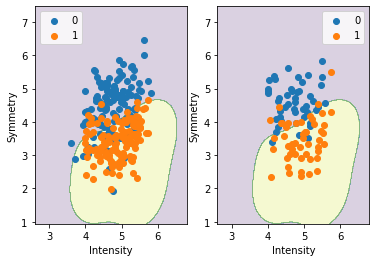

In [25]:
print("Model 7")
print("Train:", model7.score(X_tr, Y_tr))
print("Val:", model7.score(X_val, Y_val))
fig, (ax1, ax2) = plt.subplots(ncols=2)
plot_results(ax1, ax2, model7, train, val)